In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
train_im = cv2.imread('mouse_frame_0.png')
test_im = cv2.imread('mouse_frame_1.png')

print(train_im.shape, test_im.shape)

(1080, 1440, 3) (1080, 1440, 3)


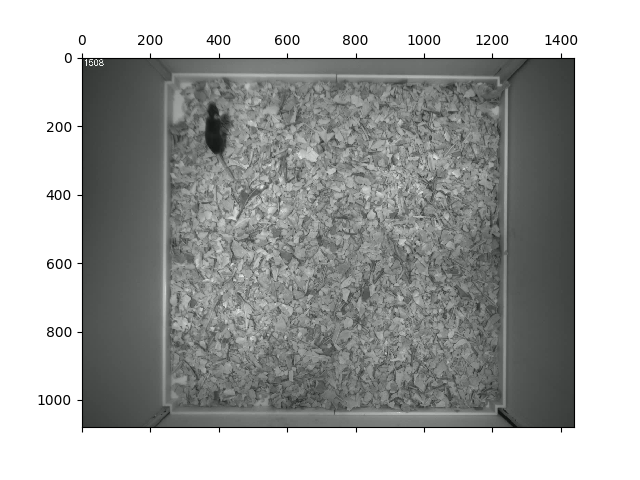

In [7]:
fig, ax = plt.subplots()
ax.matshow(train_im)
plt.show()

In [20]:
def get_mouse_location(image: np.ndarray) -> tuple[int, int]:
    value_channel = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[..., 2]
    _, value_channel = cv2.threshold(value_channel, thresh=70, maxval=255, type=cv2.THRESH_BINARY_INV)
    
    # Remove noise
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(value_channel, kernel, iterations=2)
    value_channel = cv2.dilate(eroded, kernel, iterations=2)


    contours, _ = cv2.findContours(value_channel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = list(map(cv2.contourArea, contours))

    # Filter based on area
    contours = list(filter(lambda x: areas[x[0]] > 3000 and areas[x[0]] < 7000, enumerate(contours)))
    contours = list(map(lambda x: x[1], contours))
    # update areas, now that contours have been filtered
    areas = list(map(cv2.contourArea, contours))


    ellipses = list(map(cv2.fitEllipse, contours))
    # Each ellipse is a tuple of (center, size (of full axes), angle)
    ellipse_areas = [np.pi * e[1][0] * e[1][1] / 4 for e in ellipses]
    area_ratios = [a / e for a, e in zip(areas, ellipse_areas)]

    # Want the area ratio to be close to 1
    good_indices = list(filter(lambda x: np.abs(np.log(x[1])) < 0.15, enumerate(area_ratios)))
    mouse_contour = contours[good_indices[0][0]]

    M = cv2.moments(mouse_contour)
    centroid = int(M['m10']/M['m00']), int(M['m01']/M['m00'])

    return centroid

In [21]:
print(get_mouse_location(train_im))
print(get_mouse_location(test_im))

(389, 215)
(585, 466)
